In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

In [2]:
gmeX = pd.read_csv('gmeDF-q2.csv')
gmeX = gmeX.loc[:, gmeX.columns != 'date']
gmeX = gmeX.loc[:, gmeX.columns != 'Unnamed: 0']
gmeX = gmeX.loc[:, gmeX.columns != 'daychange']
gmeX = gmeX.loc[:, gmeX.columns != 'anger']
gmeX = gmeX.loc[:, gmeX.columns != 'disgust']
gmeX = gmeX.loc[:, gmeX.columns != 'fear']
gmeX = gmeX.loc[:, gmeX.columns != 'joy']
gmeX = gmeX.loc[:, gmeX.columns != 'sadness']
gmeX = gmeX.loc[:, gmeX.columns != 'surprise']
gmeX = gmeX.loc[:, gmeX.columns != 'connectivity']
gmeX = gmeX.loc[:, gmeX.columns != 'avgdeg']

gmeX = gmeX.head(70)
gmeX

,size,edges,diameter,clustering,volume
0,39,30,4,0.000000,10022500
1,42,34,5,0.000000,4961500
2,124,112,4,0.000000,6056200
3,27,19,3,0.000000,6129300
4,21,14,2,0.000000,6482000
...,...,...,...,...,...
65,1610,2243,13,0.000325,10047400
66,1286,1742,11,0.000189,9462400
67,2167,2877,11,0.000183,16683600
68,1855,2503,13,0.000442,6806900


<Axes: >

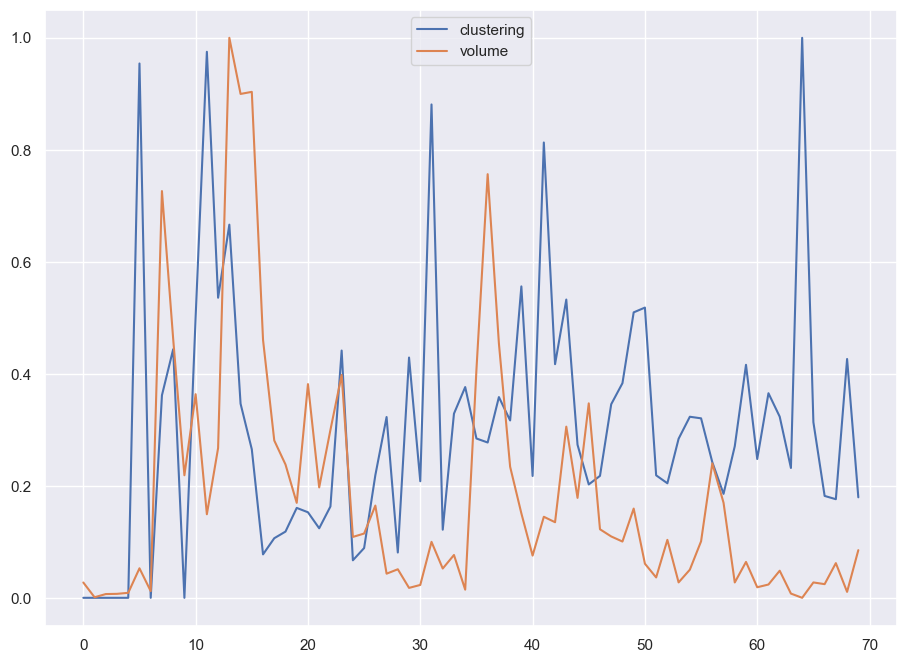

In [3]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
sns.set(rc={'figure.figsize':(11,8)})

gmeXs = scaler.fit_transform(gmeX)
gmeXs = pd.DataFrame(gmeXs,columns=['size','edges','diameter','clustering','volume'])
gmeXs[['clustering','volume']].plot()

In [4]:
for metric in gmeXs.columns:
    result = adfuller(gmeXs[[metric]])
    print('A-DF of metric',metric,'has p-value of',result[1])
    print()

A-DF of metric size has p-value of 0.00020604448462040376

A-DF of metric edges has p-value of 0.0001751968854520183

A-DF of metric diameter has p-value of 0.03515496659316675

A-DF of metric clustering has p-value of 3.861193512694202e-05

A-DF of metric volume has p-value of 0.004310334133781258



In [5]:
#build the VAR model
model = VAR(gmeXs)
print(model.select_order(5))

gme_model = model.fit(5)

gme_model.summary()

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 5, BIC -> 3, FPE -> 5, HQIC ->  3>


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 29, Aug, 2023
Time:                     12:45:18
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -23.4198
Nobs:                     65.0000    HQIC:                  -26.0527
Log likelihood:           571.322    FPE:                1.10404e-12
AIC:                     -27.7685    Det(Omega_mle):     2.05279e-13
--------------------------------------------------------------------
Results for equation size
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.018003         0.021769            0.827           0.408
L1.size              18.407833         1.027992           17.907           0.000
L1.edges            -17.375962         1.037750          -16.

Text(0, 0.5, 'Volume (0,1)')

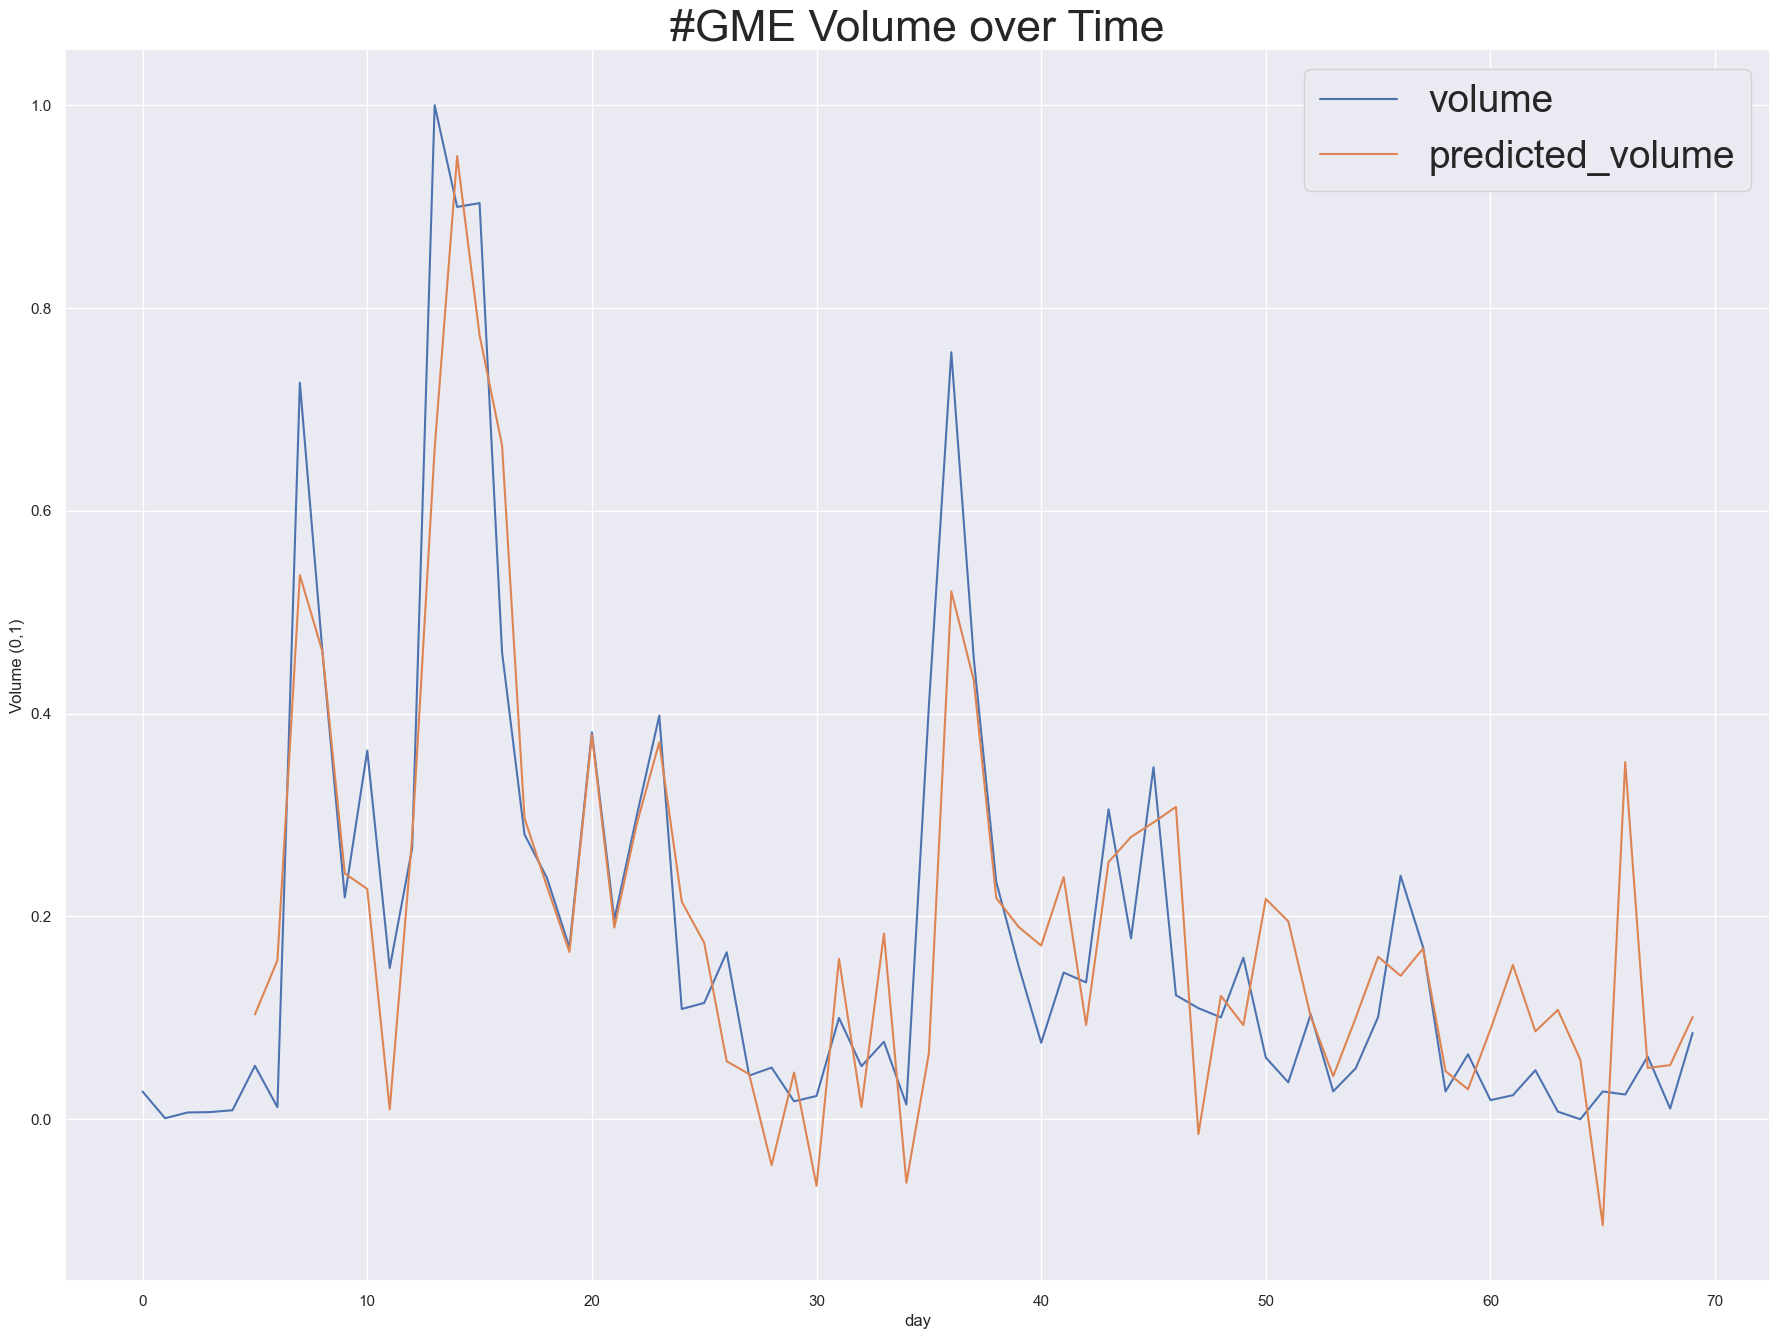

In [6]:
#forecast and plot

sns.set(rc={'figure.figsize':(22,16)})

gmeXs[['volume']].plot()
plt.plot(gme_model.fittedvalues['volume'],label='predicted_volume')
plt.legend(fontsize='28')
plt.title('#GME Volume over Time',fontsize=32)
plt.xlabel('day')
plt.ylabel('Volume (0,1)')

In [8]:
#test for causality
print(gme_model.test_causality(4,0))
print(gme_model.test_causality(4,1))
print(gme_model.test_causality(4,2))
print(gme_model.test_causality(4,3))
print(gme_model.test_causality(4,4))

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: size does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.323, critical value: 2.260>, p-value: 0.899>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: edges does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 0.256, critical value: 2.260>, p-value: 0.936>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: diameter does not Granger-cause volume: fail to reject at 5% significance level. Test statistic: 1.805, critical value: 2.260>, p-value: 0.113>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: clustering does not Granger-cause volume: reject at 5% significance level. Test statistic: 5.154, critical value: 2.260>, p-value: 0.000>
<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: volume does 

In [9]:
print('GME',mean_absolute_error(gmeXs[['volume']][5:],gme_model.fittedvalues['volume']))

GME 0.08114806378728186
